In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt
sys.path.append("../source/")
from evolutionary import *
from functools import partial
import scipy

# One-Max Function

It's a very simple (toy) example of an optimization problem for binary vector: the value to optimize is the number of 1s in the vector

$fitness(x) = \sum_{i=1}^n x_i$

In [2]:
def one_max(b: BitVectorCandidate):
    return np.sum(b.candidate)

In [3]:
max_value = 100

genalgo_one_max = GeneticAlgorithm(100,
                                   BitVectorCandidate,
                                   partial(tournament_selection, tournament_size=5),
                                   one_max,
                                   elitism=True,
                                   **{"p": 0.05, "size": max_value})

(0.0, 100.0)

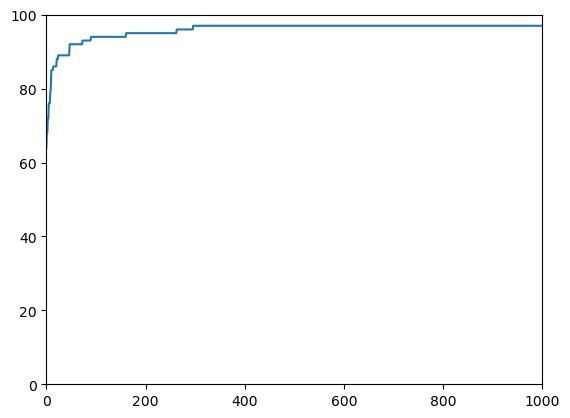

In [4]:
iters = 1000

genalgo_one_max.fit(iters, keep_history=True)
history = genalgo_one_max.fitness_h

plt.plot(history)
plt.xlim(0,iters)
plt.ylim(0,max_value)


# Trap

It is a tricky optimization problem: the value is the number of 1s -> unless you have the all 0s or the all 1s vectors:

        If all 0s -> the fitness value is n (maximum)
        
        If all 1s -> the fitness value is 0 (minimum)
        
$fitness(x) = \begin{cases}
1 & \forall i, x_i = 0\\
0 & \forall i, x_i = 1\\
\sum_i x_i & otherwise
\end{cases}$

In [5]:
def trap(b: BitVectorCandidate):
    v = np.sum(b.candidate)
    if v == 0:
        return b.size
    elif v == b.size:
        return 0
    else:
        return v

In [6]:
max_value = 100

genalgo_trap = GeneticAlgorithm(100,
                                BitVectorCandidate,
                                partial(tournament_selection, tournament_size=5),
                                trap,
                                elitism=True,
                                **{"p": 0.05, "size": max_value})

(0.0, 100.0)

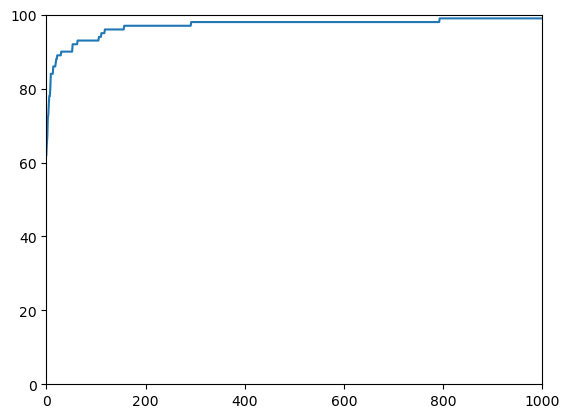

In [7]:
iters = 1000

genalgo_trap.fit(iters, keep_history=True)
history = genalgo_trap.fitness_h

plt.plot(history)
plt.xlim(0,iters)
plt.ylim(0,max_value)


# Linear

It is the real-valued version of one-max: the function to optimize is to maximize a linear function,
specified by a given vector

$f_a(x) = \sum_i a_i x_i$

In [8]:
def linear(v: FloatVectorCandidate, a: np.ndarray):
    return np.sum(v.candidate * a)

In [9]:
max_value = 10

a = np.random.rand(max_value)
print(np.sum(a))
genalgo_linear = GeneticAlgorithm(100,
                                  FloatVectorCandidate,
                                  partial(tournament_selection, tournament_size=5),
                                  partial(linear, a=a),
                                  elitism=True,
                                  **{"distribution": scipy.stats.uniform(loc=-0.05, scale=0.1),
                                     "size": max_value,
                                     "lower": 0,
                                     "upper": 1})

6.82321017175311


(0.0, 6.82321017175311)

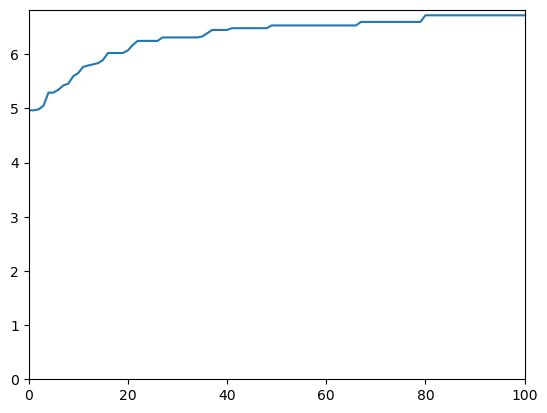

In [10]:
iters = 100

genalgo_linear.fit(iters, keep_history=True)
history = genalgo_linear.fitness_h
plt.plot(history)
plt.xlim(0,iters)
plt.ylim(0,np.sum(a))

# Rastrigin

It's a benchmark optimization problem: it is very difficult because it has a huge number of local optima

In [11]:
def rastrigin(v: FloatVectorCandidate):
    return -(10*v.size + np.sum(v.candidate*v.candidate - 10*np.cos(2*np.pi*v.candidate)))

In [12]:
max_value = 10

genalgo_rastrigin = GeneticAlgorithm(100,
                                  FloatVectorCandidate,
                                  partial(tournament_selection, tournament_size=5),
                                  rastrigin,
                                  elitism=True,
                                  **{"distribution": scipy.stats.uniform(loc=-0.05, scale=0.1),
                                     "size": max_value,
                                     "lower": -5.12,
                                     "upper": 5.12})

(0.0, 100.0)

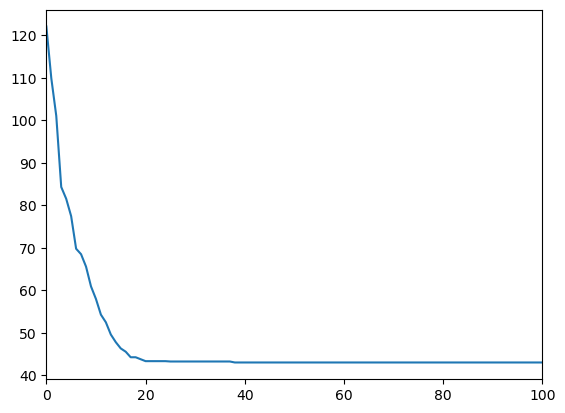

In [13]:
iters = 100

genalgo_rastrigin.fit(iters, keep_history=True)
history = genalgo_rastrigin.fitness_h
plt.plot(history*-1)
plt.xlim(0,iters)
#plt.ylim(0,np.sum(a))

# Least-Squares Linear Regression

The objective is, given a matrix of data $X$ and observations $y$ generated by $X \cdot w + \epsilon=y$ (with $w$ unknown and $\epsilon \sim N(0,1)$ being random noise), to retrieve
the unknown vector $w$. We encode this by defining a loss function by which we measure the fitness of a candidate $a$:
    
$ fitness(a) = -\sum_i (y - X[i,:] \cdot a)^2 $

In [14]:
def linear_regression(v: FloatVectorCandidate, X, y):
    return -np.sum((y - X.dot(v.candidate))*(y - X.dot(v.candidate)))

In [15]:
features = 5
instances = 30

X = scipy.stats.norm.rvs(size=(instances, features), loc=0, scale=1)
w = scipy.stats.uniform.rvs(size=features, loc=-1, scale=2)
y = X.dot(w) + scipy.stats.norm.rvs(size=(instances), loc=0, scale=1)
w

array([ 0.67029436,  0.64238201, -0.66825774,  0.86061503, -0.01489225])

In [16]:
genalgo_lr = GeneticAlgorithm(100,
                                  FloatVectorCandidate,
                                  partial(tournament_selection, tournament_size=5),
                                  partial(linear_regression, X=X, y=y),
                                  elitism=True,
                                  **{"distribution": scipy.stats.uniform(loc=-0.05, scale=0.1),
                                     "size": features,
                                     "lower": -1,
                                     "upper": 1})

(0.0, 1000.0)

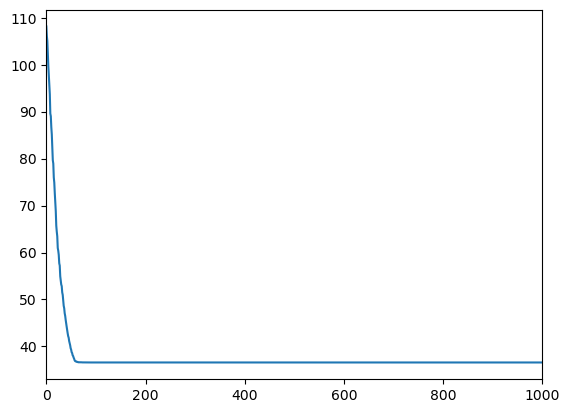

In [17]:
iters = 1000

genalgo_lr.fit(iters, keep_history=True)
history = genalgo_lr.fitness_h
plt.plot(history*-1)
plt.xlim(0,iters)
#plt.ylim(0,np.sum(a))

In [18]:
print(w)
print(genalgo_lr.best.candidate)
print(np.linalg.norm(w - genalgo_lr.best.candidate))

[ 0.67029436  0.64238201 -0.66825774  0.86061503 -0.01489225]
[ 0.50402134  0.71446937 -0.87704757  0.99998793  0.32711634]
0.46133629696513


# Hamiltonian Path
You are given a weighted directed graph $G = (V,E, w)$ represented in terms of an adjacency matrix $M_G$,
where $M_G[i,j] > 0 \text{ iff } (i,j) \in E$. An hamiltonian path is a path that visits all the vertices of $G$
and visits each vertex exactly one time.

Goal: Find an hamiltonian path with minimum weight

In [27]:
graph = np.random.choice([0,1], p=[0.75,0.25], size=(10,10))
w = np.random.rand(10,10)
graph = graph*w
graph

array([[0.33820273, 0.        , 0.34918485, 0.        , 0.58108978,
        0.        , 0.17038288, 0.96019063, 0.28743534, 0.        ],
       [0.12507947, 0.3217187 , 0.        , 0.        , 0.15404403,
        0.        , 0.18838251, 0.        , 0.        , 0.24518002],
       [0.07551454, 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.06007479, 0.        , 0.        , 0.        ,
        0.        , 0.77932168, 0.        , 0.04836341, 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.77666945, 0.93129294, 0.        , 0.        ,
        0.        , 0.        , 0.09527866, 0.67951575, 0.        ],
       [0.21815257, 0.32605035, 0.34713049, 0.72239188, 0.        ,
        0.        , 0.        , 0.72272289, 0.45047964, 0.        ],
       [0.        , 0.        , 0.7824648

# Fitness Function
The fitness penalizes paths that are longer or shorter than the number of vertices. It uses a linear penalty in which the 
difference in length (in absolute value) is weighted the maximum weight in the graph.
Also, the fitness function penalizes a path if there are some nodes that are missing or some duplicate nodes
(in this case, the path cannot be Hamiltonian), once again it uses a linear penality weighted
the maximum weight in the graph

In [28]:
def fitness_hamiltonian(c: PathCandidate):
    max_w = np.max(c.graph)
    num_vs = c.graph.shape[0]
    if len(c.path) != num_vs:
        return max_w*np.abs(num_vs - len(c.path))
    vs = np.empty(num_vs, dtype=bool)
    vs[:] = False
    
    cost = 0
    for i in c.path:
        if not vs[i]:
            vs[i] = True
        else:
            cost += max_w
            
    for i in vs:
        if i == False:
            cost += max_w
            
    for i in range(len(c.path)-1):
        cost += c.graph[c.path[i],c.path[i+1]]
    return -cost

# Genetic Algorithm
It uses a representation of candidates given by PathCandidate

## Generation
It generates a random walk in the graph, with the constraint that the length of the walk should be equal to the number
of vertices

## Mutation
It selects randomly a vertex $v$ in the current path, it keeps all vertices in the path before $v$ ($v$ included) and then
generates a random walk starting from $v$, with the constraint that the length of the walk should be equal to the number
of vertices

## Recombination
It selects randomly a vertex $v$ in the first path, it keeps all vertices in the first path before $v$ ($v$ included).
Then, it searches the first occurence of $v$ in the second path and adds all vertices after $v$ (in the second path) to the new path. If the length of the constructed path is smaller than the number of vertices, then it generates a random walk starting from the last node, with the constraint that the length of the walk should be equal to the number
of vertices

In [29]:
genalgo_ham = GeneticAlgorithm(100,
                              PathCandidate,
                              partial(tournament_selection, tournament_size=5),
                              partial(fitness_hamiltonian),
                              elitism=True,
                              **{'graph': graph})

(0.0, 1000.0)

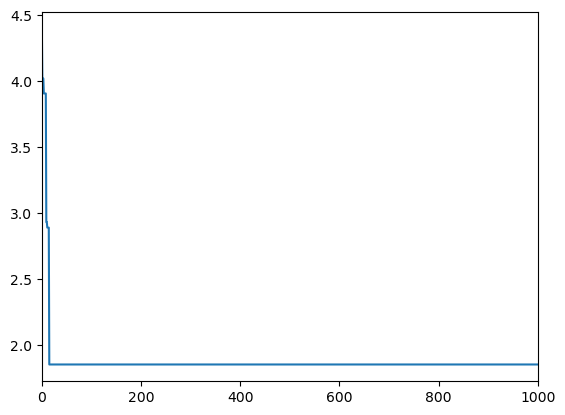

In [30]:
iters = 1000

genalgo_ham.fit(iters, keep_history=True)
history = genalgo_ham.fitness_h
plt.plot(history*-1)
plt.xlim(0,iters)
#plt.ylim(0,np.sum(a))

In [31]:
path = genalgo_ham.best.path
print(path)
print(-fitness_hamiltonian(genalgo_ham.best))
for i in range(len(path)-1):
    if graph[path[i],path[i+1]] == 0:
        print("No edge!")

[5, 7, 9, 3, 1, 6, 2, 0, 8, 4]
1.854324403687352
